<div style="text-align: center">
    <h1>Final Project</h1>
    <h5>By Abdallah Hwishel and Varun Lagadapati</h5>
</div>

<h3>Introduction</h3>

<h4>
The videogame industry has grown by 23 % since last year. It's industry value exceeded that of other forms of entertainment like the movie/show business, and it keeps on growing. This increase in interest in the videogame industry has put pressure on videogame companies to release games on a regular basis, where consumers see multiple game releases from different studios/companies every year. The purpose of this notebook is to answer big questions about the gaming industry as a whole and it's current state of being by using publicly available data like user reviews and scores for 3 of the largest game companies like Electronic Arts (EA), Ubisoft, and Activision. This will be a tutorial to teach readers about the 'data science pipeline' and it's stages.
</h4>


<h5>Data Science Pipeline for this tutorial:</h5>
<ol>
    <li>Data Collection - We will collect metacritic scores and rating quantity for different games from different companies to analyze and answer questions</li>
    <li>Data Visualization - Visualize the data using plots and figures to get a general 'feel' for the data and possible trends</li>
    <li>Exploratory Data Analysis - 'Crunch the numbers' and see if we can learn something from it</li>
    <li>Hypothesis Testing - The 'science' part of data science where we hypothesize, test, and make conclusions</li>
    <li>Communication Of Insights - We will communicate what we learned in a readable format</li>
</ol>

<h3>The Big Question</h3>

<h4><b>Has the quality of games made by major game companies dropped after 2014?</b></h4>
<p>To answer that question, we first need to get some data, then we try and look for general trends and patterns in the data, and build some assumptions and get some intuition. After that we analyize the data in a way that lets us answer specific questions that leads to hypotheses. From there we test our hypothesis and make conclusions. Finally, we will communicate the findings in a coherent manner. The data we'll be using to answer this big question among other related yet smaller questions are user review scores as well as the amount of ratings. We'll use the user review scores as a measurement of quality for any particular game if it exists on metacritic, and we'll use the number of ratings to guage how popular a game is and whether there was any "hype" for it. To start we'll use wikipedia to get a list of games from the listed 3 companies.</p>

Note: The reason why we'll use wiki pages is because they listed all the games made for these companies across different periods of time typically spanning 10 years. <a href="https://en.wikipedia.org/wiki/List_of_Ubisoft_games:_2000%E2%80%932009">Here's</a> an example of all ubisoft games between 2000-2009 in a nice tabular format.

In [321]:
#IMPORTS - These are general imports we will use
import pandas as pd
import numpy as np
import matplotlib as mp
import re

#DEBUG CODE
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

<h3>Part I: Data Collection</h3>

In [322]:
#PART I - Data Collection

#Wiki-links:
ubisoft_games = ['https://en.wikipedia.org/wiki/List_of_Ubisoft_games:_2000%E2%80%932009', 
                 'https://en.wikipedia.org/wiki/List_of_Ubisoft_games:_2010%E2%80%932019', 
                 'https://en.wikipedia.org/wiki/List_of_Ubisoft_games:_2020%E2%80%93present']
ea_games = ['https://en.wikipedia.org/wiki/List_of_Electronic_Arts_games:_2000%E2%80%932009',
            'https://en.wikipedia.org/wiki/List_of_Electronic_Arts_games:_2010%E2%80%93present']
activision_games = ['https://en.wikipedia.org/wiki/List_of_Activision_games:_2000%E2%80%932009',
                    'https://en.wikipedia.org/wiki/List_of_Activision_games:_2010%E2%80%932019',
                    'https://en.wikipedia.org/wiki/List_of_Activision_games:_2020%E2%80%93present']

#Company Dataframes for different years in a list
ubisoft_releases = [pd.read_html(ubisoft_games[0])[1], pd.read_html(ubisoft_games[1])[1], pd.read_html(ubisoft_games[2])[1]]
ea_releases = [pd.read_html(ea_games[0])[1], pd.read_html(ea_games[1])[1]]
activision_releases = [pd.read_html(activision_games[0])[0], pd.read_html(activision_games[1])[0], pd.read_html(activision_games[2])[0]]

#Example of the list of games ubisoft released between 2000 and 2009
ubisoft_releases[0].head()

,Title,Platform(s),Release date,Developer(s),Ref.
0,Papyrus,Game Boy Color,February 2000,Planet Interactive Development,NaN
1,Theocracy,Linux,"March 1, 2000",Philos Laboratories,NaN
2,Theocracy,Microsoft Windows,"March 1, 2000",Philos Laboratories,NaN
3,Inspector Gadget: Operation Madkactus,Game Boy Color,"March 14, 2000",RFX Interactive,[1]
4,Rayman 2: The Great Escape,Dreamcast,"March 21, 2000",Ubi Soft,[2]


We can see from the top of the table shown above that we have several columns which are the titles of the games, the platforms they were released on, their release dates, and their developers and some column called Ref. As we can see, there are columns that are more useful than others like the title and release data columns, and some columns that are of no use to use like the Ref column. This Ref column contained hyperlinks for navigation purposes on the wiki page and provides no signficance to our analysis. So we need to clean the dataframes to contain only information that is useful to us. The two main things we have to do is filter games such that we get games that were released at 2005 and beyond, remove the Ref columns in all the dataframes, and finally combine all the games released for a particular company in one big dataframe.

In [323]:
#Join each companies dataframes of releases from different time periods into one
ubisoft_df = pd.concat(ubisoft_releases)
ea_df = pd.concat(ea_releases)
activision_df = pd.concat(activision_releases)

#First lets reset the index on the new dataframe because now we have entries that have the same index which can make our lives harder
ubisoft_df = ubisoft_df.reset_index(drop=True)
ea_df = ea_df.reset_index(drop=True)
activision_df = activision_df.reset_index(drop=True)

#Now lets remove all games where release date is TBA because they're not released yet, and so we have no use for it
ubisoft_df = ubisoft_df[ubisoft_df["Release date"] != 'TBA'][:-1] #There reason why I exclude the last row is because it was relative to an unreleased dlc
ea_df = ea_df[ea_df["Release date"] != 'TBA']
activision_df = activision_df[activision_df["Release date"] != 'TBA']

#Now we have to isolate the year from the release date. It's a string so we need to only slice out the last 4 digits and convert that to an int
for i in range(len(ubisoft_df)):
    ubisoft_df["Release date"][i] = int(ubisoft_df["Release date"][i][-4:])

for i in range(len(ea_df)):
    ea_df["Release date"][i] = int(ea_df["Release date"][i][-4:])

for i in range(len(activision_df)):
    activision_df["Release date"][i] = int(activision_df["Release date"][i][-4:])

#Filter dates such that we're looking at games between 2005 and 2021
#This will remove any releases before 2005 and games aren't released yet

#We'll make a function to do just that so that it looks more elegant
def filter(df,col_name,start, end):
    filter_before_start = df[df[col_name] >= start]
    filter_after_end = filter_before_start[filter_before_start[col_name] <= end]
    return filter_after_end

#Give me the values between 2005 and 2021 for all the dataframes
ubisoft_df = filter(ubisoft_df, "Release date", 2005, 2021).sort_values(by="Release date").reset_index(drop=True)
ea_df = filter(ea_df, "Release date", 2005, 2021).sort_values(by="Release date").reset_index(drop=True)
activision_df = filter(activision_df, "Release date", 2005, 2021).sort_values(by="Release date").reset_index(drop=True)

#Finally let's remove that useless Ref column
ubisoft_df = ubisoft_df.drop(columns="Ref.")
ea_df = ea_df.drop(columns="Ref(s)") #In the EA dataframe the Ref column is labeled as Ref(s) not Ref.
activision_df = activision_df.drop(columns="Ref.")

ubisoft_df.head()

,Title,Platform(s),Release date,Developer(s)
0,Tork: Prehistoric Punk,Xbox,2005,Tiwak
1,Myst V: End of Ages,Microsoft Windows,2005,Cyan Worlds
2,Marathon Manager,Microsoft Windows,2005,Geronimo Entertainment
3,Myst V: End of Ages,Mac OS,2005,Beenox
4,Far Cry Instincts,Xbox,2005,Ubisoft Montreal


In [324]:
ubisoft_df.tail()

,Title,Platform(s),Release date,Developer(s)
1232,Far Cry 6,Xbox Series X/S,2021,Ubisoft Toronto / Ubisoft Berlin / Ubisoft Kyi...
1233,Discovery Tour: Viking Age,Microsoft Windows,2021,Ubisoft Montreal
1234,Discovery Tour: Viking Age,PlayStation 4,2021,Ubisoft Montreal
1235,Far Cry 6,PlayStation 4,2021,Ubisoft Toronto / Ubisoft Berlin / Ubisoft Kyi...
1236,Monopoly Madness,Xbox One,2021,Engine Software


Now that we have our dataframes cleaned up, however there is one last problem we have to deal with to proceed and get the metacritic scores for those lists of games. As you can see from the tables above, some games are repeated multiple times due to the fact that they exist on different gaming platforms and pandas tries to account for every single occurence. We need a way to merge those platforms into one row where the platforms are comma separated.

In [325]:
#Lets start with getting a list of games without duplicates for each company
ubisoft_titles = ubisoft_df['Title'].drop_duplicates()
ea_titles = ea_df['Title'].drop_duplicates()
activision_titles = activision_df['Title'].drop_duplicates()

#Let's make a function that will merge all platforms into one entry so that each game would have one entry
def merge_platforms(games, df, platform_string): #The platform_string is because each dataframe's platforms column name is slightly different
    rows = [] #We'll put row values in here
    for game in games:
        game_entries = df[df['Title'] == game]
        platforms_list = list(game_entries[platform_string])
        #set switch to lower case, remove Amazon Luna and Stadia because Stadia flopped and Luna is an unreleased "platform"
        for i,platform in enumerate(platforms_list):
            if platform == 'Nintendo Switch':
                platforms_list[i] = 'switch'
            elif platform == 'Amazon Luna' or platform == 'Stadia' or platform == 'Mobile phones' or platform == 'iOS' or platform == 'Android' or platform == 'N-Gage':
                platforms_list[i] = "-" #I will replace it so that I can remove it later. I can't delete it now while the list is iterating
            elif platform == 'PlayStation Portable':
                platforms_list[i] = 'psp'
            elif platform == 'Nintendo 3DS':
                platforms_list[i] = '3ds'
            elif platform == 'Nintendo DS':
                platforms_list[i] = 'ds'
            elif platform == 'Xbox Series X/S':
                platforms_list[i] = 'xbox-series-x'
            elif platform == 'Microsoft Windows' or platform == 'Windows':
                platforms_list[i] = 'pc'
        if "-" in platforms_list:
            platforms_list.remove('-')
        platforms_joined = ','.join(platforms_list).lower().replace(' ', '-')
        release_date = game_entries.iloc[0]['Release date']
        developers = game_entries.iloc[0]['Developer(s)']
        new_entry = [game, platforms_joined, release_date, developers]
        rows.append(new_entry)
    return pd.DataFrame(data=rows, columns=['titles', 'platforms', 'release_date', 'developers'])

updated_ubisoft_df = merge_platforms(ubisoft_titles, ubisoft_df, 'Platform(s)')
updated_ea_df = merge_platforms(ea_titles, ea_df, 'Platforms')
updated_ea_df = updated_ea_df[updated_ea_df['platforms'] != '-'] #I have to do this because there were some mobile exclusives to be removed
updated_activision_df = merge_platforms(activision_titles, activision_df, 'Platform(s)')
updated_activision_df = updated_activision_df[updated_activision_df['platforms'] != ''] #I have to do this because there were some weird consoles like N-Gage???

We now have the platforms listed in a way that's useful to us programmatically. The reason why we include code that puts the string in all lower case and replaces whitespace with the '-' character is because we are trying to format the dataframe such that it's immediately usable to make requests to metacritic's website. An example url for Battlefield V's metacritic page for the PlayStation 4 looks like this <a href="https://www.metacritic.com/game/playstation-4/battlefield-v">https://www.metacritic.com/game/playstation-4/battlefield-v</a>

Some things to note about the URL:
<ol>
    <li>The base url seems to be <b style="color: green">https://www.metacritic.com/game/</b> -> Example: <b style="color: green">https://www.metacritic.com/game/</b>playstation-4/battlefield-v , <b style="color: green">https://www.metacritic.com/game/</b>playstation-2/spider-man-2</li>
    <li>platform names have special formatting. Ex: PlayStation 4 = playstation-4, Nintendo Switch = switch, etc.</li>
    <li>The game name seems to have special formatting as well.</li>
    <ul>
        <li>Sometimes games might have special characters like ':' or ','. An example would be FINAL FANTASY XV: WINDOWS EDITION -> final-fantasy-xv-windows-edition</li>
    </ul>
</ol>

So it seems that we need to account for the last point. Let's make a function that would convert a game's name to the url friendly version

In [326]:
#This function will take the original game's name and convert it to the metacritic url format
def convert_game_name(game):
    game = ''.join(game.strip().split('[')[:1])
    splitName = re.split("\s|: |-|, |&| – | - ", game)
    splitName = [elem for elem in splitName if elem != ''] #remove any remaining empty strings
    if '–' in splitName:
        splitName.remove('–')
    url_converted_name = '-'.join(splitName).lower().replace("'", "") #replace single quote chars
    if '–' in url_converted_name: #I have to check again because sometimes urls have --- in it
        url_converted_name = url_converted_name.replace('–', "-")
    if '.' in url_converted_name:
        url_converted_name = url_converted_name.replace('.','')    
    return url_converted_name

#lets add a new column to the dataframes to contain the converted names so that we have both in the same dataframe.
updated_ubisoft_df["converted_name"] = [convert_game_name(name) for name in list(updated_ubisoft_df["titles"])]
updated_ea_df["converted_name"] = [convert_game_name(name) for name in list(updated_ea_df["titles"])]
updated_activision_df["converted_name"] = [convert_game_name(name) for name in list(updated_activision_df["titles"])]

updated_ubisoft_df.head()

,titles,platforms,release_date,developers,converted_name
0,Tork: Prehistoric Punk,xbox,2005,Tiwak,tork-prehistoric-punk
1,Myst V: End of Ages,"pc,mac-os",2005,Cyan Worlds,myst-v-end-of-ages
2,Marathon Manager,pc,2005,Geronimo Entertainment,marathon-manager
3,Far Cry Instincts,xbox,2005,Ubisoft Montreal,far-cry-instincts
4,Lunar: Dragon Song,ds,2005,Japan Art Media,lunar-dragon-song


Now we're ready to make some requests to the metacritic site. For that we will use the requests library to get the html for the metacritic page from which we will scrape our data like user ratings using a library called "beautifulsoup". We need to do a couple of things first before we start. We'll need to import <em>beautifulsoup</em> and <em>requests</em> library.

In [327]:
import requests as r
from bs4 import BeautifulSoup as BS

We'll need to familiarize ourselves with the beautifulsoup's <a href="https://www.scrapingbee.com/blog/python-web-scraping-beautiful-soup/">documentation</a> to be able to use it. Feel free to consult it while you look through the code to see what function calls do what.

In [328]:
#Let's start by making a simple request to metacritic and familiarize ourselves with how to use scrapy to extract the user review scores.

#We'll start by looking through the documentation. Let's pull something from this metacritic url: https://www.metacritic.com/game/playstation-4/injustice-2

#We'll put this in a try except block because requests could cause an error if request is blocked
try:
    injustice2_req_response = r.get("https://www.metacritic.com/game/playstation-4/injustice-2")
except:
    print("Request timed out")

Request timed out


We've ran into a common roadblock that usually comes with requests, and that is when a request times out, or gets blocked by the server. This problem happens occassionally when the the server receives a request that carries no information with it like where it came from, why kind of information that request is expecting back, etc. This kind of information is stored as what's known as request headers. If a request arrives with no headers occasionally a server with security measures would block such requests to protect itself from being flooded with requests by bots, which in this request's current state, might as well look like a bot request. So let's make some headers that we will send with the request. Thankfully we don't have to guess what kind of information its looking for when it comes to headers, because our browsers typically do that for us. You can go to any browser you wish, put the url above in it, and go to the browser's inspect menu once you arrive at the page. In my case I'm using google chrome, so I'll be showing steps that are relative to chrome. Please follow the steps below to arrive at the requests page.

NOTE: Find highlighted text or parts

Step 1: Go to the url of interest

<img src="./step1.jpg">

Step 2: Right click anywhere on the page and click on inspect. This will open the chrome dev tools that gives us info about the page and network stats.

<img src="./step2.jpg">

Step 3: You'll notices either a window pops up as part of the browser or off the browser as a separate window. Thats the chrome dev tool. Find the Network tab and click it.

<img src="./step3.jpg">

Step 4: You will find a weird tab with a bunch of things on it. We're interested in the lower half of the tab where we see a table with a bunch of columns. One column called Name is the one we're interested in. You might find that it's either empty or has a couple of things, but defintely not many things. We need to refresh the page while the dev tools are open one more time so that we see more things appear in the tab.

<img src="./step4.jpg">

Step 5: The "things" mentioned in step 4 are basically elements of the page that had to travel through the network to be a part of the page like images, the web page itself, some scripts related google ads and what not. We want to find the webpage itself in the Name column. It should have the same name as the game itself. So since we're looking at Injustice 2, it will be called injustice-2. This isn't a convention or anything but that's typically how the webpages are named based on observation from other metacritic pages using the same steps here. Once you locate it, click on it to view information about it. A panel on its right should appear.

<img src="./step5.jpg">

Step 6: Scroll down the panel on the right till you find a drop down panel called "Request Headers". This is from which we will be copying our values to put in our own request headers. We do this so that the request we make in the script resembles that of the browser. See the code block below to see what headers I chose to include.

<img src="./step6.jpg">

In [329]:
#Copy only these ones from the headers, as the rest is already filled in by the requests library
headers = {
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "en-US,en;q=0.9",
    "cache-control": "no-cache",
    "pragma": "no-cache",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
}

try:
    injustice2_req_response = r.get("https://www.metacritic.com/game/playstation-4/injustice-2", headers=headers)
    print("Request Status Code:",injustice2_req_response.status_code, " -> which = SUCCESS")
except:
    print("Request timed out")

Request Status Code: 200  -> which = SUCCESS


Now that we passed in headers that will make the request look less suspicious to the server, it now processes the request and sends us back a response. From this response we can retrieve the html for the page from which we will extract our review scores and numbers. That's where beautifulsoup comes in.

In [330]:
injustice2_page_content = injustice2_req_response.content #If I print this it will look really ugly like so

print("HTML: \n")
injustice2_page_content[:500] #Showing first 500 characters in the page

HTML: 



b'<!DOCTYPE html>\n<html lang="en">\n<head>\n        \t<title>Injustice 2 for PlayStation 4 Reviews - Metacritic</title>\n\t\n    \n    <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n\n    \n    <meta name="description" content="Metacritic Game Reviews, Injustice 2 for PlayStation 4, Every battle defines you. Power up and build the ultimate version of your favorite DC legends in INJUSTICE 2. With a massive selection of...">\n\n    \n    \n    <meta name="viewport" content="width=1024">\n\n   '

This is really ugle and hard to read. Luckily, we do not have to read the html here to find our tags of interest (our scores and rating count). We can use the chrome dev tools to find that for us as mentioned in the tutorial I linked above, but <a href="https://www.scrapingbee.com/blog/python-web-scraping-beautiful-soup/">here</a> it is again in case you don't want to scroll all the way up.

In [331]:
soup = BS(injustice2_page_content, 'html.parser')

soup

<!DOCTYPE html>

<html lang="en">
<head>
<title>Injustice 2 for PlayStation 4 Reviews - Metacritic</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="Metacritic Game Reviews, Injustice 2 for PlayStation 4, Every battle defines you. Power up and build the ultimate version of your favorite DC legends in INJUSTICE 2. With a massive selection of..." name="description"/>
<meta content="width=1024" name="viewport"/>
<meta content="Metacritic" name="application-name"/>
<meta content="#000000" name="msapplication-TileColor"/>
<meta content="/images/win8tile/76bf1426-2886-4b87-ae1c-06424b6bb8a2.png" name="msapplication-TileImage"/>
<meta content="618k3mbeki8tar7u6wvrum5lxs5cka" name="facebook-domain-verification">
<meta content="Injustice 2" property="og:title"/>
<meta content="game" property="og:type"/>
<meta content="https://www.metacritic.com/game/playstation-4/injustice-2" property="og:url"/>
<meta content="https://static.metacritic.com/images/produc

This is how beautiful soup views our webpage content. It makes it easier on itself to extract/scrape data from it. Let's get our user scores from the page

There is a very handy chrome extension that lets you extract the relevant selectors for a particular element in the page to help with identify the element without much trouble. This extension is called <em>SelectorGadget</em>. You can find a tutorial of SelectorGadget <a href="https://selectorgadget.com/">here</a>.

In [332]:
#use soup.find([id="x" or class_="y"]) to get the element of interest.
injustice2_user_score = soup.find(class_="large").text
rating_amount = soup.find('a', href="/game/playstation-4/injustice-2/user-reviews", class_=None).text.split(" ")[0]
print(f"The injustice 2 user score is {injustice2_user_score} on the playstation 4 with {rating_amount} ratings")

The injustice 2 user score is 8.0 on the playstation 4 with 794 ratings


Okay, now that we know what code to write to extract the user scores and rating amounts for ALL the games in the dataframes above. We would have to be cautious though. Some of the games in the dataframe above don't have user scores, and sometimes it wouldn't have a user score for all the platforms of a game if it does exist. So we need to be able to handle those to avoid errors. The way metacritic stores its reviews for any game is that it has a separate page for each game depending on the platform. So for every platform the game is on, there is a page for that. Let's define a function that will do just that for us.

In [333]:
def create_url_from_game(name,platform):
    #end result should look like this: https://www.metacritic.com/game/playstation-4/injustice-2
    base_url = "https://www.metacritic.com/game/"
    url_name = f"{base_url}{platform}/{name}"
    return url_name

def collect_user_scores_for_games_list(df):
    # scores_and_ratings = {} #we'll store the game's info in a key-value pair format to make our lives easier.
    scores_and_ratings = []
    for idx, (titles,platforms,release_date,developers,converted_name) in df.iterrows():
        for platform in platforms.split(","):
            url = create_url_from_game(converted_name, platform)
            try:
                response = r.get(url,headers=headers)
                html = response.content
                soup = BS(html,'html.parser')
                user_score = soup.find(class_="large").text
                rating_amount = soup.find('a', href=f"{url[26:]}/user-reviews", class_=None).text.split(" ")[0]
                # if scores_and_ratings[titles] == None:
                #     scores_and_ratings[titles]= [{"score": user_score, "rating amt": rating_amount, "platform": platform}]
                # else:
                #     scores_and_ratings[titles].append({"score": user_score, "rating amt": rating_amount, "platform": platform})
                scores_and_ratings.append([titles, platform, user_score, rating_amount, release_date])
            except:
                print(f"request for {url} timed out")
    return pd.DataFrame(data=scores_and_ratings, columns=['title', 'platform', 'score', 'ratings', 'year'])

Because this takes time, we will run each in a cell of its own. By our estimates this should take about an hour total to get all the data. Talk about RIP.

In [334]:
#I left this commented out because in total this takes a long time to run and I've saved the outcome of it in a csv file from a previous run
#If you want to try it out and see if it works you can uncomment it and let it run

# activision_scores_and_ratings = collect_user_scores_for_games_list(updated_activision_df)

In [335]:
#Code that I used from the first run to make a csv file out of the dataframe.

#Show the dataframe and save it to a csv file so we don't have to run these requests again
# activision_scores_and_ratings.to_csv('./activision_scores_and_ratings.csv', index=False)
# activision_scores_and_ratings

In [336]:
#I left this commented out because in total this takes a long time to run and I've saved the outcome of it in a csv file from a previous run
#If you want to try it out and see if it works you can uncomment it and let it run

# ubisoft_scores_and_ratings = collect_user_scores_for_games_list(updated_ubisoft_df)

In [337]:
#Code that I used from the first run to make a csv file out of the dataframe.

# ubisoft_scores_and_ratings.to_csv('./ubisoft_scores_and_ratings.csv', index=False)
# ubisoft_scores_and_ratings

In [338]:
# ea_scores_and_ratings = collect_user_scores_for_games_list(updated_ea_df)

In [339]:
#Code that I used from the first run to make a csv file out of the dataframe.

# ea_scores_and_ratings.to_csv('./ea_scores_and_ratings.csv', index=False)
# ea_scores_and_ratings

In [340]:
#Reassign the scores_and_ratings variables to use the csv files instead because we'll leave the code that sends requests commented out
#for the sake of saving time when running the notebook

ubisoft_scores_and_ratings = pd.read_csv('./ubisoft_scores_and_ratings.csv')
ubisoft_scores_and_ratings = ubisoft_scores_and_ratings[ubisoft_scores_and_ratings['score'] != 'tbd']

ea_scores_and_ratings = pd.read_csv('./ea_scores_and_ratings.csv')
ea_scores_and_ratings = ea_scores_and_ratings[ea_scores_and_ratings['score'] != 'tbd']

activision_scores_and_ratings = pd.read_csv('./activision_scores_and_ratings.csv')
activision_scores_and_ratings = activision_scores_and_ratings[activision_scores_and_ratings['score'] != 'tbd']

ubisoft_scores_and_ratings['score'] = ubisoft_scores_and_ratings['score'].astype(float)
ea_scores_and_ratings['score'] = ea_scores_and_ratings['score'].astype(float)
activision_scores_and_ratings['score'] = activision_scores_and_ratings['score'].astype(float)

combined_scores_and_ratings = pd.concat([ubisoft_scores_and_ratings, ea_scores_and_ratings, activision_scores_and_ratings])


print(f"We started with this many games: {len(ubisoft_titles) + len(ea_titles) + len(activision_titles)}, but ended with this many games: {len(combined_scores_and_ratings['title'].drop_duplicates())}")
combined_scores_and_ratings

We started with this many games: 1439, but ended with this many games: 909


,title,platform,score,ratings,year
0,Tork: Prehistoric Punk,xbox,6.2,6,2005
1,Myst V: End of Ages,pc,7.6,58,2005
2,Far Cry Instincts,xbox,6.0,82,2005
3,Lunar: Dragon Song,ds,5.3,20,2005
4,Tom Clancy's Rainbow Six: Lockdown,gamecube,7.8,5,2005
...,...,...,...,...,...
704,Call of Duty: Vanguard,playstation-5,3.5,1307,2021
705,Call of Duty: Vanguard,playstation-4,4.1,148,2021
706,Call of Duty: Vanguard,pc,3.2,644,2021
707,Call of Duty: Vanguard,xbox-one,4.0,115,2021


In [341]:
#Let's make a dataframe where now we average the scores for every game

def average_game_scores(df):
    rows = []
    titles = list(df['title'].drop_duplicates())
    for title in titles:
        sub_df = df[df['title'] == title]
        mean_score = round(np.mean(list(sub_df['score'])),2)
        total_rating = sum([int(elem) for elem in list(sub_df['ratings'])])
        rows.append([title, ','.join(list(sub_df['platform'])),mean_score, sub_df.iloc[0]['ratings'], sub_df.iloc[0]['year']])
    return pd.DataFrame(data=rows, columns=['title', 'platform', 'score', 'ratings', 'year'])

ubisoft_avg_scores_and_ratings = average_game_scores(ubisoft_scores_and_ratings)
ea_avg_scores_and_ratings = average_game_scores(ea_scores_and_ratings)
activision_avg_scores_and_ratings = average_game_scores(activision_scores_and_ratings)
combined_avg_scores_and_ratings = pd.concat([ubisoft_avg_scores_and_ratings, ea_avg_scores_and_ratings, activision_avg_scores_and_ratings])

We can see that while filtering the dataframe and fetching the data, we've lost some games in the process. This is what's known in datascience as missing values. When you have missing values, there are various methods of "imputations" depending on why the missing values are missing. In our case, the games that did not get included in the final combined dataframe are due to:
<ol>
    <li>Differences in the naming of games between the wikipedia pages and metacritic. Ex: <em>Need For Speed: Most Wanted</em> [how it is on wiki] vs <em>Need For Speed: Most Wanted (2005)</em> [how it is on metacritic]. Since we can't simply comb through a thousand games and look at the name differences this is data simply</li>
    <li>Some platforms listed for games on wikipedia don't have a metacritic page. So we can't get any data on it.</li>
    <li>A lot of the games that weren't included were due to the fact that they're either mobile games or games on platforms that don't exist until later parts of the periods of study, like Google's Stadia that launched in 2019 and Amazon Luna (announced but not launched yet)</li>
</ol>

<b>Verdict:</b> This is data that is "Missing Not At Random". That is because the value (i.e. the score and rating) of a game is missing is related to the reason it's missing (the reasons listed above). You can read more about missing data <a href="https://www.mastersindatascience.org/learning/how-to-deal-with-missing-data/">here</a> and how to handle them. The way we chose to handle was to simply not include it in the dataset.

<h3>Part II + III: Data Visualization & Exploratory Data Analysis</h3>

Alright, now that we finally have our data, let's start making plots and see what the data looks like as a whole, as separate entities, and and both during different periods of time.

For this section we'll rely heavily on a plotting library called <em>Matplotlib</em>. It's a popular python library that's used in data visualization due to it's rich plotting functionality that allows for making scatter plots, box plots, etc. There are many other libraries that achieve the same result as matplotlib like seaborn, but we chose this library simply because familiar with it more.

In [342]:
#PART II: Data Visualization

#import library we'll use to make plots.
import matplotlib.pyplot as plt

Now that we have matplotlib library imported. Let's start by making plots of scores and ratings for each company.

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_22700\3953058070.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ubisoft_score_plot.set_xticklabels(years)


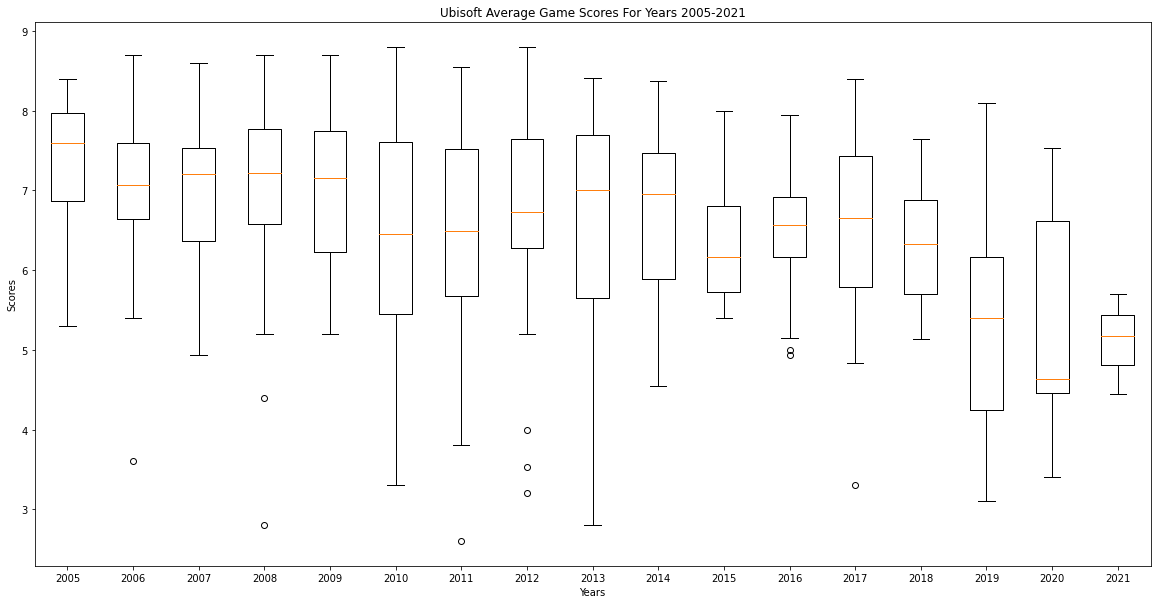

In [343]:
#Ubisoft Plot

years = list(combined_scores_and_ratings['year'].drop_duplicates())

scores_per_year = [list(ubisoft_avg_scores_and_ratings[ubisoft_avg_scores_and_ratings['year'] == year]['score']) for year in years]

fig, ubisoft_score_plot = plt.subplots(figsize=(20,10))
ubisoft_score_plot.set_xticklabels(years)
ubisoft_score_plot.set_xlabel("Years")
ubisoft_score_plot.set_ylabel("Scores")
ubisoft_score_plot.set_yticks([i for i in range(0,11)])
ubisoft_score_plot.set_title("Ubisoft Average Game Scores For Years 2005-2021")
# ubisoft_score_plot.scatter(x=list(ubisoft_scores_and_ratings['year']), y=list(ubisoft_scores_and_ratings['score']))
ubisoft_score_plot.boxplot(scores_per_year)
plt.show()

In [344]:
print(f"Ubisoft's Lowest Score: {np.min(list(ubisoft_avg_scores_and_ratings['score']))} for {ubisoft_avg_scores_and_ratings[ubisoft_avg_scores_and_ratings['score'] == 2.6].iat[0,0]}")
print(f"Ubisoft's Highest Score: {np.max(list(ubisoft_avg_scores_and_ratings['score']))} for {ubisoft_avg_scores_and_ratings[ubisoft_avg_scores_and_ratings['score'] == 8.8].iat[0,0]}")

Ubisoft's Lowest Score: 2.6 for ABBA: You Can Dance
Ubisoft's Highest Score: 8.8 for No More Heroes 2: Desperate Struggle


From the graph above, we can see that the median scores (yellow lines) for each year is not uniform, and they float around between scores of 5 and 8. We also see various spreads for each year, which means that for a given year the narrower the spread the more concentrated the data points around a particular set of scores. For example, the spread of scores for the year 2005 shows that the majority games released that year are centered around scores between 7 and 8. The top and bottom ticks represent the max and min scores respectively, and the circles above and below those ticks are outliers, which are data points that are extreme in nature compared to the rest of the data and thus can't be matched to the larger trend of the data. We see that the lowest score game ubisoft ever released between 2005 and 2021 was in 2020. The code above indicates that it's Just dance while the highest score game that ubisoft ever released bewteen 2005 and 2021 was Tom Clancy's Splinter Cell: Chaos Theory. Overall, we see a slow yet steady decreasing trend in the value of the medians.

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_22700\1557843471.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ea_score_plot.set_xticklabels(years)


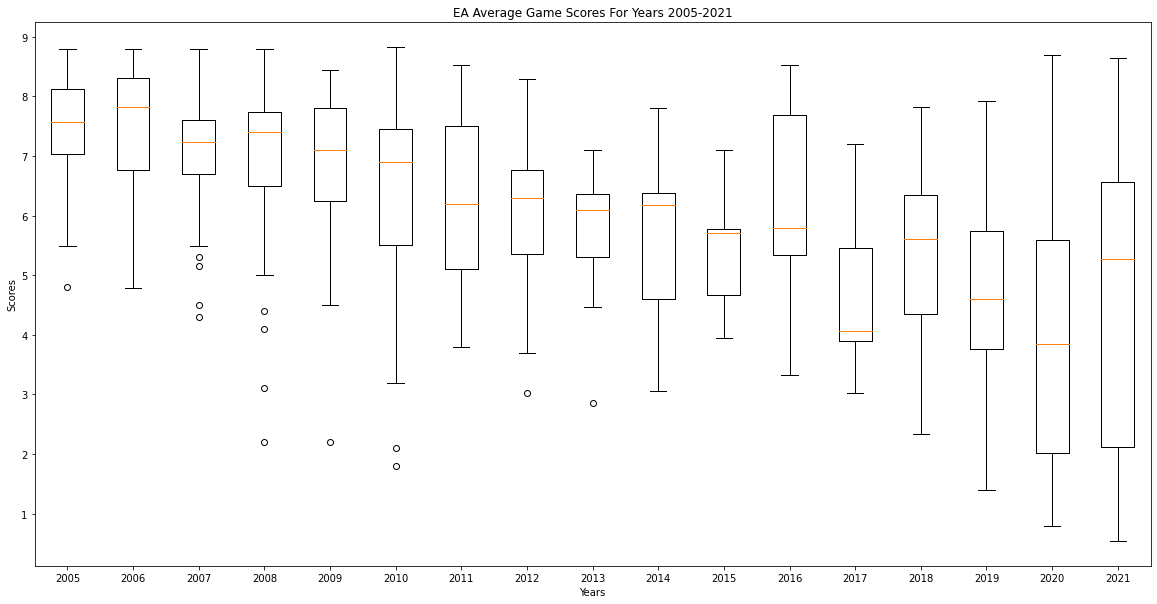

In [345]:
#EA Plot
scores_per_year = [list(ea_avg_scores_and_ratings[ea_avg_scores_and_ratings['year'] == year]['score']) for year in years]

fig, ea_score_plot = plt.subplots(figsize=(20,10))
ea_score_plot.set_xticklabels(years)
ea_score_plot.set_xlabel("Years")
ea_score_plot.set_ylabel("Scores")
ea_score_plot.set_yticks([i for i in range(0,11)])
ea_score_plot.set_title("EA Average Game Scores For Years 2005-2021")
# ea_score_plot.scatter(x=list(ubisoft_scores_and_ratings['year']), y=list(ubisoft_scores_and_ratings['score']))
ea_score_plot.boxplot(scores_per_year)
plt.show()

EA's general trend for the medians seems to be steadily decreasing over all, with a few increases here and there, while the spread seems to be getting larger and larger. EA seems to be releasing alot more games in the lsat 2 years compared to the rest of the time period. The same behavior is prevalent for the min and max values of the plot. This shows a steady decrease in quality of EA games.

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_22700\3617640842.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  activision_score_plot.set_xticklabels(years)


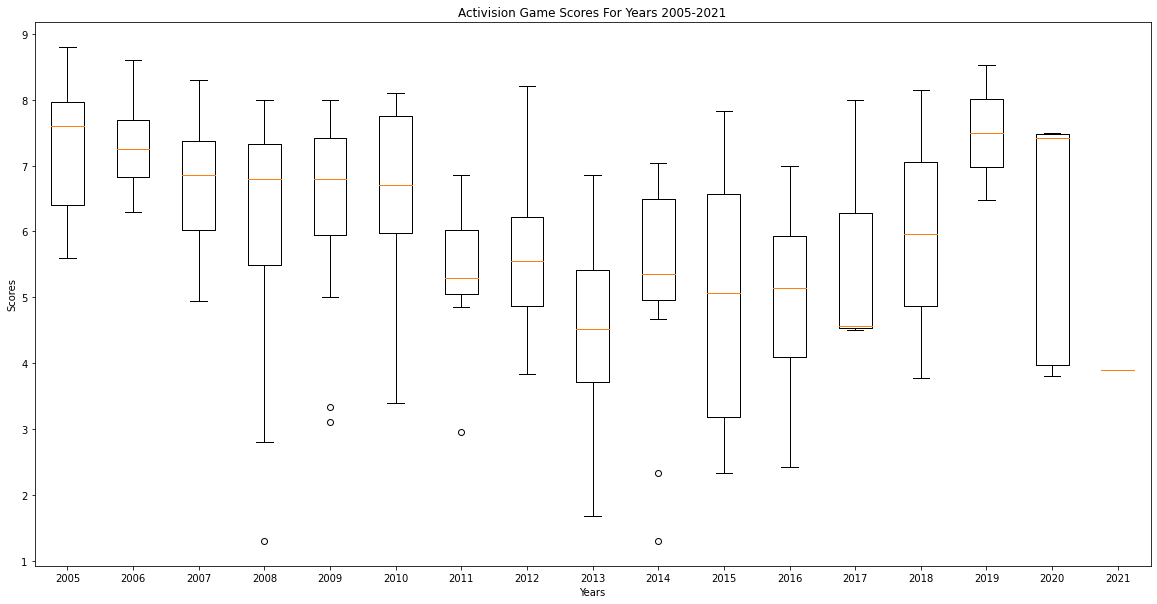

In [346]:
#Activision Plot
scores_per_year = [list(activision_avg_scores_and_ratings[activision_avg_scores_and_ratings['year'] == year]['score']) for year in years]

fig, activision_score_plot = plt.subplots(figsize=(20,10))
activision_score_plot.set_xticklabels(years)
activision_score_plot.set_xlabel("Years")
activision_score_plot.set_ylabel("Scores")
activision_score_plot.set_yticks([i for i in range(0,11)])
activision_score_plot.set_title("Activision Game Scores For Years 2005-2021")
# activision_score_plot.scatter(x=list(ubisoft_scores_and_ratings['year']), y=list(ubisoft_scores_and_ratings['score']))
activision_score_plot.boxplot(scores_per_year)
plt.show()

Activisions dataset is a bit more difficult to look at as the medians shift up and down all over the place. However, we can see that there was a steady decrease until 2013, where it reached a point of inflection and the trend started rising upwards. Unlike the previous 2 companies, activision did not release as many games, especially during the last year in the whole period.

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_22700\2205056272.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  combined_score_plot.set_xticklabels(years)


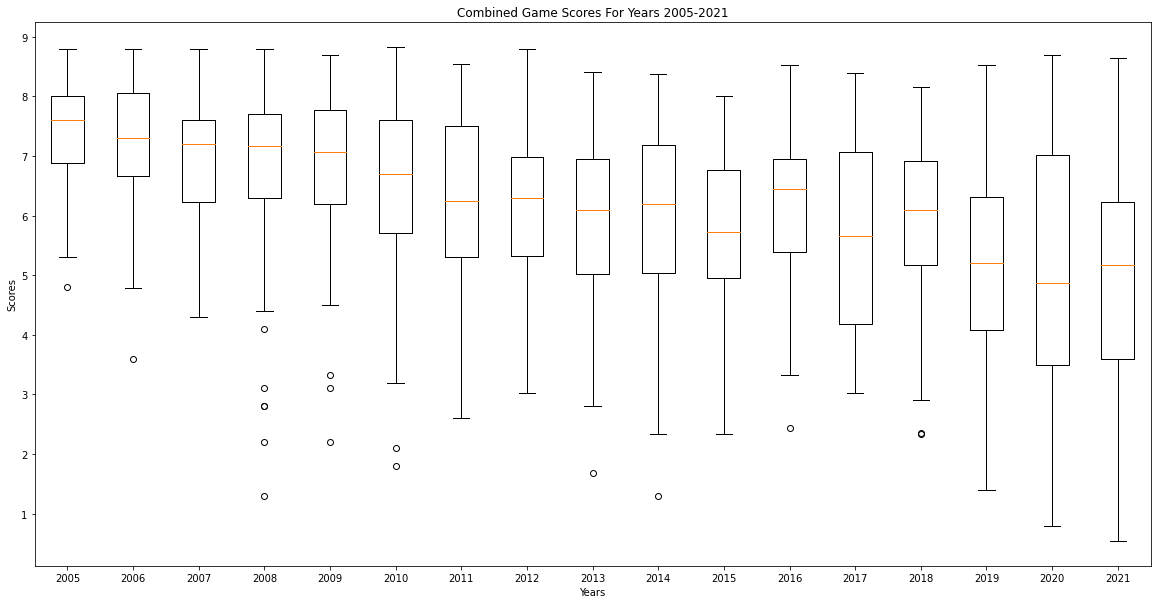

In [347]:
#Combined Plot
scores_per_year = [list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] == year]['score']) for year in years]

fig, combined_score_plot = plt.subplots(figsize=(20,10))
combined_score_plot.set_xticklabels(years)
combined_score_plot.set_xlabel("Years")
combined_score_plot.set_ylabel("Scores")
combined_score_plot.set_yticks([i for i in range(0,11)])
combined_score_plot.set_title("Combined Game Scores For Years 2005-2021")
# combined_score_plot.scatter(x=list(combined_scores_and_ratings['year']), y=list(combined_scores_and_ratings['score']))
combined_score_plot.boxplot(scores_per_year)
plt.show()

Now the culmination of all those companies' data across a 17 year period shows a slow but steady decrease in metacritic scores which hints that the quality of games has also been dropping overall. We can confirm this definitively by using a regression line for the time before 2014, the time after 2014, and both combined.

Slope of regression line: -0.1824434201929645


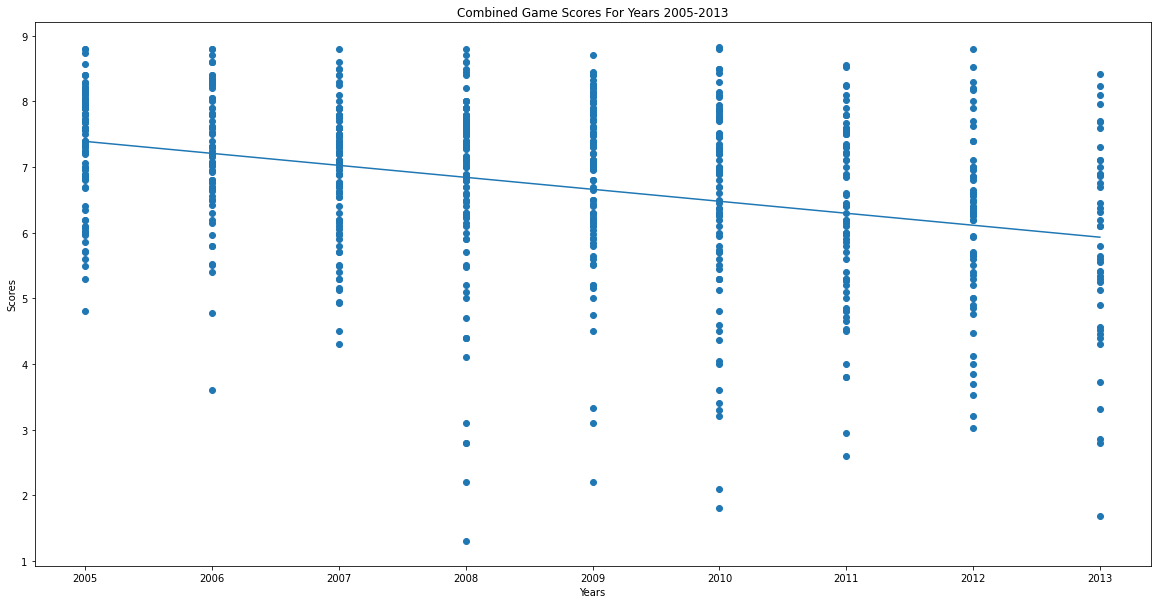

In [348]:
#Before 2014

fig, combined_score_plot = plt.subplots(figsize=(20,10))
combined_score_plot.set_xlabel("Years")
combined_score_plot.set_ylabel("Scores")
combined_score_plot.set_yticks([i for i in range(0,11)])
combined_score_plot.set_title("Combined Game Scores For Years 2005-2013")
combined_score_plot.scatter(x=list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] < 2014]['year']), y=list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] < 2014]['score']))
m, b = np.polyfit(list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] < 2014]['year']), list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] < 2014]['score']), 1)
plt.plot(list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] < 2014]['year']), m*np.array(list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] < 2014]['year']))+b)

print(f"Slope of regression line: {m}")

For all the game scores we have during 2013 and prior (before 2014) we see that there was already a decreasing trend in terms of user scores which shows a decrease in quality in games as the years progress.

Slope of regression line: -0.18530555734951382


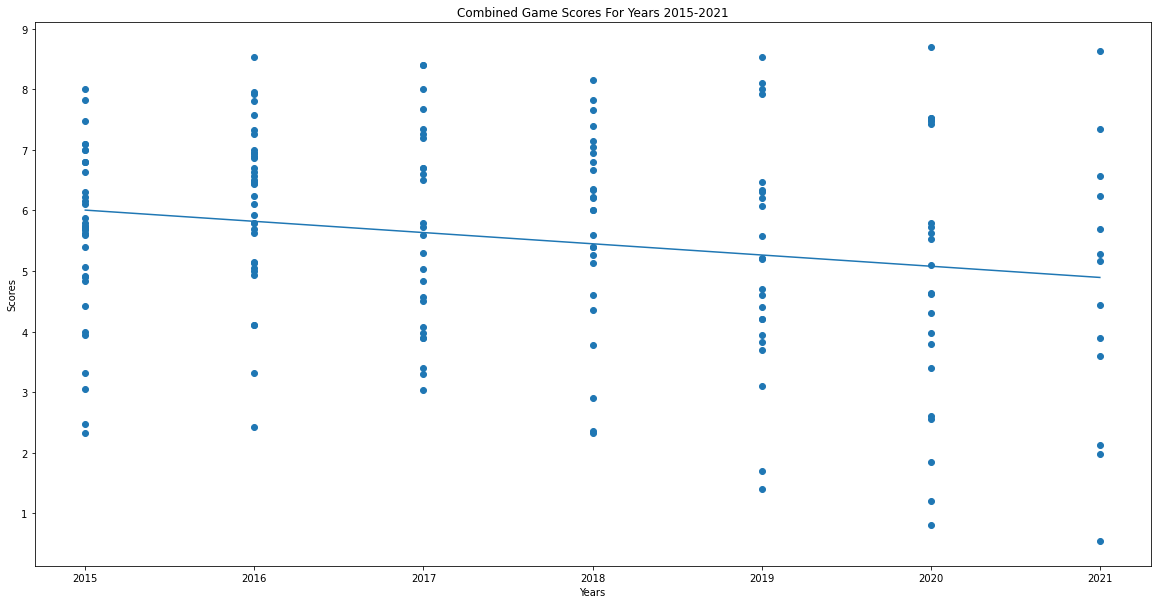

In [349]:
#After 2014

fig, combined_score_plot = plt.subplots(figsize=(20,10))
combined_score_plot.set_xlabel("Years")
combined_score_plot.set_ylabel("Scores")
combined_score_plot.set_yticks([i for i in range(0,11)])
combined_score_plot.set_title("Combined Game Scores For Years 2015-2021")
combined_score_plot.scatter(x=list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] > 2014]['year']), y=list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] > 2014]['score']))
m, b = np.polyfit(list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] > 2014]['year']), list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] > 2014]['score']), 1)
plt.plot(list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] > 2014]['year']), m*np.array(list(combined_avg_scores_and_ratings[combined_avg_scores_and_ratings['year'] > 2014]['year']))+b)

print(f"Slope of regression line: {m}")

For the games that were released during 2015 and after (after 2014 but not including), we see a similar trend trend of a decrease in user scores of games as the years progress which shows a decrease in quality as the years go on. It's evident due a decrease in the slope of the regression line (-0.182 [<2014] vs. -0.185 [>2014])

Slope of regression line: -0.1478604153679248


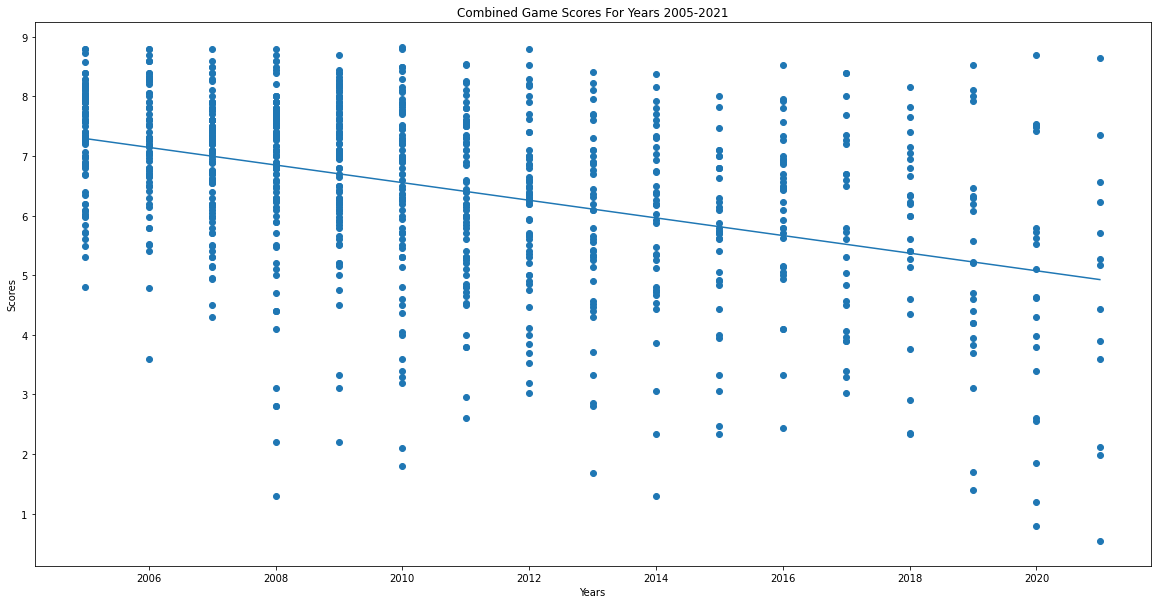

In [354]:
#The combined averages plot

fig, combined_score_plot = plt.subplots(figsize=(20,10))

combined_score_plot.set_xlabel("Years")
combined_score_plot.set_ylabel("Scores")
combined_score_plot.set_yticks([i for i in range(0,11)])
combined_score_plot.set_title("Combined Game Scores For Years 2005-2021")
combined_score_plot.scatter(x=list(combined_avg_scores_and_ratings['year']), y=list(combined_avg_scores_and_ratings['score']))
m, b = np.polyfit(list(combined_avg_scores_and_ratings['year']), list(combined_avg_scores_and_ratings['score']), 1)
plt.plot(list(combined_avg_scores_and_ratings['year']), m*np.array(list(combined_avg_scores_and_ratings['year']))+b)

print(f"Slope of regression line: {m}")

When combined together, the regression line's slope dramatically decreases where it now includes the games from 2014 so as to maintain continuity in the graph. Regardless it's clear that the overall trend is a decreasing one when it comes to user scores. This shows a general drop in quality of games between 2005 and 2021.

How did the consoles generally perform compared to one another?

C:\Users\Abdallah\AppData\Local\Temp\ipykernel_22700\3371689121.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  console_plot.set_xticklabels(['GC', 'PSP', 'PS2', 'Xbox', 'GBA', 'DS', 'Switch', 'X360', 'Wii', 'PS3', 'PC', 'Wii-U', 'PSVita', 'XBONE', 'PS4', 'XSX', 'PS5', '3DS'])


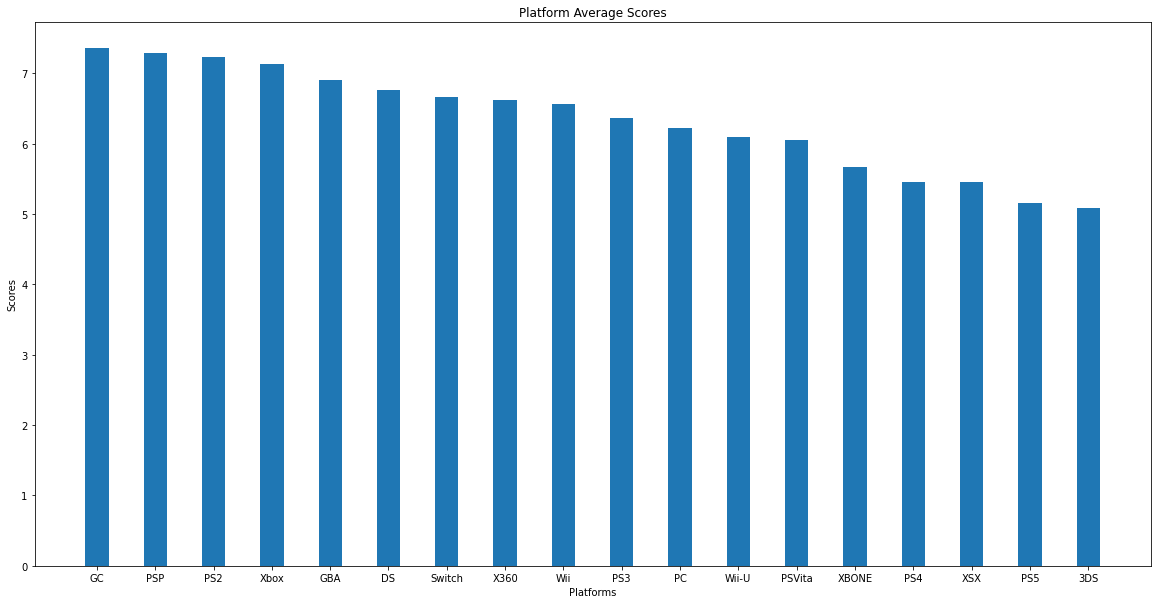

In [350]:
#Console performance based on rating

platforms = list(combined_scores_and_ratings['platform'].drop_duplicates())
platform_avg_scores = []

for platform in platforms:
    platform_score_mean = np.mean(list(combined_scores_and_ratings[combined_scores_and_ratings['platform'] == platform]['score']))
    platform_avg_scores.append([platform, round(platform_score_mean,2)])

platform_avg_scores_df = pd.DataFrame(data=platform_avg_scores, columns=['platform', 'avg_score'])

platform_avg_scores_df = platform_avg_scores_df.sort_values(by='avg_score', ascending=False)
platform_avg_scores_df

fig, console_plot = plt.subplots(figsize=(20,10))
console_plot.set_xticklabels(['GC', 'PSP', 'PS2', 'Xbox', 'GBA', 'DS', 'Switch', 'X360', 'Wii', 'PS3', 'PC', 'Wii-U', 'PSVita', 'XBONE', 'PS4', 'XSX', 'PS5', '3DS'])
console_plot.set_xlabel("Platforms")
console_plot.set_ylabel("Scores")
console_plot.set_yticks([i for i in range(0,11)])
console_plot.set_title("Platform Average Scores")
console_plot.bar(platforms, list(platform_avg_scores_df['avg_score']), width=0.4)
plt.show()

When averaging the game scores per console, it seemed that original xbox, playstation 2, gamecube, and psp had the best average scores. Those consoles were older console generations that existed prior to 2010. Compare that to next generation consoles like the playstation 3, xbox 360, and the wii, you'll see that their scores decreased compared to the consoles that came before them. We can also see a similar trend with every new generation of consoles with the average scores decreasing compared to the previous generation. In general, it seems that the older generation consoles out performed their successors during that period of time.

<h3>Part IV: Hypothesis Testing</h3>

Null Hypothesis: H0 = Assume that the quality of games have dropped after 2014 and the mu score after 2014 is less than the mu score before 2014.  

Alternative Hypothesis: H1 = The quality of games didn't drop after 2014 and the mu score after 2014 is greater than or equal to the mu score before 2014. 

H0: mu after 2014 <= mu before 2014

H1: mu after 2014 > mu before 2014

In [351]:
# Z-Test

combined_scores_and_ratings_before_2014 = combined_scores_and_ratings[combined_scores_and_ratings['year'] < 2014]
combined_scores_and_ratings_after_2014 = combined_scores_and_ratings[combined_scores_and_ratings['year'] >= 2014]

total_mu = np.mean([float(elem) for elem in list(combined_scores_and_ratings['score'])])
total_std = np.std([float(elem) for elem in list(combined_scores_and_ratings['score'])])

combined_scores_and_ratings_sample = combined_scores_and_ratings.sample(n = int(0.1 * len(combined_scores_and_ratings)))

mu_before2014 = np.mean([float(elem) for elem in list(combined_scores_and_ratings_before_2014['score'])])
mu_after2014 = np.mean([float(elem) for elem in list(combined_scores_and_ratings_after_2014['score'])])
sd_before2014 = np.std([float(elem) for elem in list(combined_scores_and_ratings_before_2014['score'])])
sd_after2014 = np.std([float(elem) for elem in list(combined_scores_and_ratings_after_2014['score'])])

combined_scores_and_ratings_before_2014_sample = combined_scores_and_ratings_before_2014.sample(n=int(0.1 * len(combined_scores_and_ratings_before_2014)))
combined_scores_and_ratings_after_2014_sample = combined_scores_and_ratings_after_2014.sample(n=int(0.1 * len(combined_scores_and_ratings_after_2014)))

mu_before2014_sample = np.mean([float(elem) for elem in list(combined_scores_and_ratings_before_2014_sample['score'])])
mu_after2014_sample = np.mean([float(elem) for elem in list(combined_scores_and_ratings_after_2014_sample['score'])])
sd_before2014_sample = np.std([float(elem) for elem in list(combined_scores_and_ratings_before_2014_sample['score'])])
sd_after2014_sample = np.std([float(elem) for elem in list(combined_scores_and_ratings_after_2014_sample['score'])])

print(mu_before2014_sample, mu_after2014_sample, sd_before2014_sample, sd_after2014_sample)  
print(sd_after2014)
print(len(combined_scores_and_ratings_after_2014_sample))

# Population: mu after 2014 = 5.58 and sd after 2014 = 1.92
# Sample mu before 2014 = 6.76
# Sample mu after 2014 = 5.62
# Sample sd before 2014 = 1.41
# Sample sd after 2014 = 1.95
# Sample: N = 69
# sd_M = sd after 2014/sqrt(N) = 1.92/sqrt(69) = 0.23 
# z = (sample mu after 2014 - mu after 2014)/sd_M = (5.62 - 5.58)/(0.23) = (0.04)/(0.23) = 0.17

6.744099378881986 5.952173913043478 1.3799290971297056 1.8299923731251675
1.9159791230509196
69


The z score is 0.17 and the z score for the critical value is 1.645 based on this <a href="https://www.itl.nist.gov/div898/handbook/eda/section3/eda3672.htm">link</a>. This link shows the student's t distribution table at the bottom with the z score of 1.645 and using 95% confidence level which means that the alpha is 1 - 0.95 = 0.05. Since 0.17 < 1.645, we fail to reject the null hypothesis using the upper-tailed test.

<h3>Part V: Communication Of Insights</h3>